In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

In [8]:
random.seed(42)

N = 500  # incident sayısı

sources = [
    "Database",
    "Application",
    "Network",
    "Authentication",
    "Infrastructure"
]

systems = [
    "ERP",
    "Finance",
    "CRM",
    "HR",
    "Warehouse",
    "Reporting"
]

error_types = {
    "Database": [
        "DB_TIMEOUT",
        "CONNECTION_POOL_EXHAUSTED",
        "SLOW_QUERY",
        "REPLICATION_LAG",
        "DISK_FULL"
    ],
    "Application": [
        "SERVICE_DOWN",
        "API_ERROR",
        "NULL_POINTER_EXCEPTION",
        "CONFIG_MISMATCH",
        "DEPENDENCY_FAILURE"
    ],
    "Network": [
        "PACKET_LOSS",
        "LATENCY_SPIKE",
        "DNS_FAILURE",
        "ROUTING_LOOP",
        "FIREWALL_BLOCK"
    ],
    "Authentication": [
        "LOGIN_FAILURE_RATE_HIGH",
        "TOKEN_EXPIRED",
        "PERMISSION_DENIED",
        "SSO_UNAVAILABLE",
        "ACCOUNT_LOCKED"
    ],
    "Infrastructure": [
        "CPU_SATURATION",
        "MEMORY_LEAK",
        "DISK_IO_WAIT",
        "VM_RESTART",
        "NODE_UNREACHABLE"
    ]
}

rows = []

start_time = datetime.now() - timedelta(days=30)

for i in range(N):
    source = random.choice(sources)
    system = random.choice(systems)
    error = random.choice(error_types[source])

    row = {
        "incident_id": f"INC-{1000+i}",
        "timestamp": start_time + timedelta(minutes=random.randint(0, 60*24*30)),
        "source": source,
        "system": system,
        "error_type": error,
        "affected_users": random.randint(1, 300),
        "past_frequency": random.randint(0, 10),
        "avg_resolution_time": random.randint(5, 240)
    }

    rows.append(row)

df = pd.DataFrame(rows)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   incident_id          500 non-null    object        
 1   timestamp            500 non-null    datetime64[ns]
 2   source               500 non-null    object        
 3   system               500 non-null    object        
 4   error_type           500 non-null    object        
 5   affected_users       500 non-null    int64         
 6   past_frequency       500 non-null    int64         
 7   avg_resolution_time  500 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 31.4+ KB


In [10]:
df.head()

,incident_id,timestamp,source,system,error_type,affected_users,past_frequency,avg_resolution_time
0,INC-1000,2025-11-25 21:41:25.317284,Database,ERP,SLOW_QUERY,115,2,193
1,INC-1001,2025-11-18 17:09:25.317284,Database,Reporting,DISK_FULL,217,0,12
2,INC-1002,2025-12-07 18:10:25.317284,Database,Finance,CONNECTION_POOL_EXHAUSTED,14,8,55
3,INC-1003,2025-12-05 04:51:25.317284,Infrastructure,HR,MEMORY_LEAK,143,0,199
4,INC-1004,2025-11-30 05:50:25.317284,Application,Reporting,CONFIG_MISMATCH,143,2,60


In [32]:
def assign_severity(row):
    critical_errors = [
        "DB_TIMEOUT",
        "SERVICE_DOWN",
        "SSO_UNAVAILABLE",
        "DISK_FULL"
    ]

    # CRITICAL (daraltıldı)
    if (
        (row["affected_users"] >= 150 and row["avg_resolution_time"] >= 120)
        or (
            row["system"] in ["ERP", "Finance"]
            and row["avg_resolution_time"] >= 150
            and row["past_frequency"] >= 3
        )
        or (
            row["error_type"] in critical_errors
            and row["affected_users"] >= 50
        )
    ):
        return "Critical"

    # MEDIUM (genişletildi)
    if (
        20 <= row["affected_users"] < 150
        or 45 <= row["avg_resolution_time"] < 150
        or row["past_frequency"] in [2, 3]
    ):
        return "Medium"

    # LOW (bilinçli alan açıldı)
    return "Low"


In [33]:
df["severity"] = df.apply(assign_severity, axis=1)

In [34]:
print(df["severity"].value_counts())

severity
Medium      253
Critical    205
Low          42
Name: count, dtype: int64


In [35]:
df.head()

,incident_id,timestamp,source,system,error_type,affected_users,past_frequency,avg_resolution_time,severity
0,INC-1000,2025-11-25 21:41:25.317284,Database,ERP,SLOW_QUERY,115,2,193,Medium
1,INC-1001,2025-11-18 17:09:25.317284,Database,Reporting,DISK_FULL,217,0,12,Critical
2,INC-1002,2025-12-07 18:10:25.317284,Database,Finance,CONNECTION_POOL_EXHAUSTED,14,8,55,Medium
3,INC-1003,2025-12-05 04:51:25.317284,Infrastructure,HR,MEMORY_LEAK,143,0,199,Medium
4,INC-1004,2025-11-30 05:50:25.317284,Application,Reporting,CONFIG_MISMATCH,143,2,60,Medium


In [39]:
from sklearn.model_selection import train_test_split

target = "severity"
X = df.drop(columns=[target, "incident_id", "timestamp"])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    


In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

cat_cols = ["source", "system", "error_type"]
num_cols = ["affected_users", "past_frequency", "avg_resolution_time"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",  # sınıflar dengesizse yardımcı olur
    n_jobs=None
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

clf.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[37  2  2]
 [ 0  5  3]
 [ 8 15 28]]

Classification Report:
               precision    recall  f1-score   support

    Critical       0.82      0.90      0.86        41
         Low       0.23      0.62      0.33         8
      Medium       0.85      0.55      0.67        51

    accuracy                           0.70       100
   macro avg       0.63      0.69      0.62       100
weighted avg       0.79      0.70      0.72       100



In [42]:
import numpy as np

proba = clf.predict_proba(X_test)
pred = clf.predict(X_test)

res = X_test.copy()
res["true"] = y_test.values
res["pred"] = pred

# En emin olup yanlış bildikleri
confidence = proba.max(axis=1)
res["confidence"] = confidence

wrong = res[res["true"] != res["pred"]].sort_values("confidence", ascending=False)
wrong.head(10)


,source,system,error_type,affected_users,past_frequency,avg_resolution_time,true,pred,confidence
294,Authentication,Warehouse,LOGIN_FAILURE_RATE_HIGH,134,7,59,Medium,Low,0.938608
48,Network,HR,DNS_FAILURE,5,7,164,Low,Medium,0.911826
209,Authentication,ERP,LOGIN_FAILURE_RATE_HIGH,48,6,29,Medium,Low,0.804851
203,Authentication,Reporting,SSO_UNAVAILABLE,42,5,160,Medium,Critical,0.801764
337,Database,Finance,DB_TIMEOUT,161,6,43,Critical,Low,0.794595
301,Database,ERP,SLOW_QUERY,246,8,110,Medium,Critical,0.728763
437,Infrastructure,Warehouse,MEMORY_LEAK,55,2,82,Medium,Low,0.724430
439,Network,HR,FIREWALL_BLOCK,154,5,159,Critical,Medium,0.722481
442,Authentication,CRM,LOGIN_FAILURE_RATE_HIGH,103,9,144,Medium,Low,0.668213
94,Database,HR,SLOW_QUERY,85,7,240,Medium,Critical,0.664385


In [43]:
print(df["severity"].value_counts())


severity
Medium      253
Critical    205
Low          42
Name: count, dtype: int64


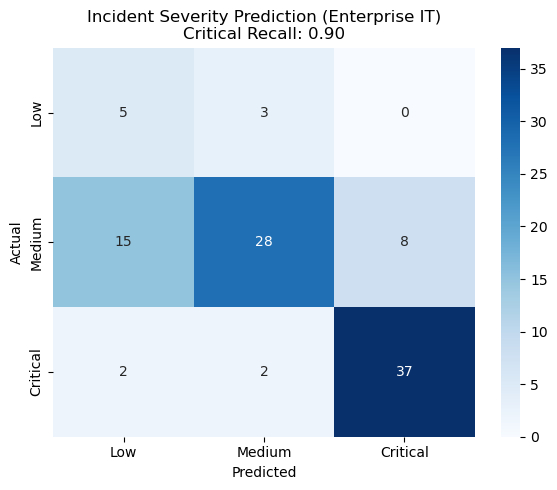

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = ["Low", "Medium", "Critical"]
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Incident Severity Prediction\n(Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(
    "Incident Severity Prediction (Enterprise IT)\n"
    "Critical Recall: 0.90",
    fontsize=12
)


plt.tight_layout()
plt.show()
